In [115]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn.metrics as sk_metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import tempfile
import statsmodels.api as sm
import os
from tensorflow import keras
import statsmodels.formula.api as smf

from tensorflow.keras import layers
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
import pymssql
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from tqdm import tqdm
import numpy as np
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from xgboost import plot_importance


# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2.9.0


In [146]:
conn = pymssql.connect(server='localhost', user='sa', password='Passw0rd!', database='Loans_2023_01_27')
cursor = conn.cursor()

def get_column_index(cursor, column_name):
    for index, col in enumerate(cursor.description):
        if col[0] == column_name:
            return index

additional_data_headers = ["RentMortgagePayment" ,"TotalIncome" ,"RentMortgage" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles"]
additional_data_sql = "VIN,"
for i, header in enumerate(additional_data_headers):
    additional_data_sql += header
    if i!=len(additional_data_headers)-1:
        additional_data_sql+=','

headers = []
rows = []

# Underwriting Data
cursor.execute("SELECT * FROM dbo.UnderwritingData")

for entity in cursor.description:
    headers.append(entity[0])

vin_index = get_column_index(cursor, "VIN")

res = cursor.fetchone()
while res:
    row = [element for element in res]
    if row[vin_index] is not None:
        row[vin_index] = row[vin_index]
        rows.append(row)
    res = cursor.fetchone()

df = pd.DataFrame(rows, columns=headers)


#Additional Data
cursor.execute("Select {vCols} FROM dbo.VerificationsDec".format(vCols = additional_data_sql))

addl_data_rows = []
res = cursor.fetchone()

while res:
    row = [element for element in res]
    row[0] = row[0].strip()
    addl_data_rows.append(row)
    res = cursor.fetchone()

print("Assigning Additional Entities")
for data in tqdm(addl_data_rows):
    df.loc[df['VIN']==data[0].strip(), additional_data_headers] = data[1:]

#Results from RawAlgorithmData
cursor.execute("SELECT Vin6,ProcStatsCd,Delq FROM dbo.RawAlgorithmData")
res = cursor.fetchone()
loan_results = dict()
delq_results = dict()
while res:
    vin6 = res[0].strip()
    if len(vin6)==17:
        # print("adding")
        loan_results[vin6] = res[1].strip()
        delq_results[vin6] = res[2]
    res = cursor.fetchone()

default_result = ["NA" for i in range(len(df))]
default_delq = ["NA" for i in range(len(df))]
df['Result'] = default_result
df['Delq'] = default_delq

df = df[df['OpeningBalance']!=0]

print("Assigning Results")
for vin6, res in tqdm(loan_results.items()):
    # print(vin6)
    df.loc[df['VIN'] == vin6, ['Result', 'Delq']] = [res, delq_results[vin6]]
    # print(df.loc[df['VIN'] == vin6])

df = df[["RentMortgagePayment" ,"TotalIncome" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles", "OpeningBalance","Salary","Term","VehicleYear","CreaditScore","LTV","DTI","TradelinesTotal","TradelinesBalance","Reposessions","Bankrupcies","Chageoff","Mortgage","NinetyDaysDelinquent","InquiresTotal","OpenTotal","ClosedTotalTermsNotPaid","LatePaymentHistory001230","LatePaymentHistory001260","LatePaymentHistory001290Plus","PaidAccounts","InquiriesLast6Months","OpenTotalInBadStatus","CurrentPaymentsMade","RentMortgage","CashDown","HomeOwner", "Delq", "Result"]]

print(df)
dfCLOnly = df.copy(deep=True)
dfCLOnly = dfCLOnly[(dfCLOnly['Result']=='CL')]
dfCLOnly['Result'].replace(to_replace=['CO', 'CL'], value=[0,1], inplace=True)
dfCLOnly['HomeOwner'].replace(to_replace=['N', 'Y'], value=[0,1], inplace=True)
dfCLOnly['DelqPct'] = dfCLOnly.apply(lambda row : (100*row['Delq'])/row['OpeningBalance'],axis=1)
dfCLOnly.fillna(dfCLOnly.mean(), inplace=True)


df = df[(df['Result']=='CO') | (df['Result']=='CL')]
df['Result'].replace(to_replace=['CO', 'CL'], value=[0,1], inplace=True)
df['HomeOwner'].replace(to_replace=['N', 'Y'], value=[0,1], inplace=True)
df['DelqPct'] = df.apply(lambda row : (100*row['Delq'])/row['OpeningBalance'],axis=1)
df.fillna(df.mean(), inplace=True)

df = df[["RentMortgagePayment" ,"TotalIncome" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles", "OpeningBalance","Salary","Term","VehicleYear","CreaditScore","LTV","DTI","TradelinesTotal","TradelinesBalance","Reposessions","Bankrupcies","Chageoff","Mortgage","NinetyDaysDelinquent","InquiresTotal","OpenTotal","ClosedTotalTermsNotPaid","LatePaymentHistory001230","LatePaymentHistory001260","LatePaymentHistory001290Plus","PaidAccounts","InquiriesLast6Months","OpenTotalInBadStatus","CurrentPaymentsMade","RentMortgage","CashDown","HomeOwner", "DelqPct"]]

dfCLOnly = dfCLOnly[["RentMortgagePayment" ,"TotalIncome" ,"CarPayment" ,"Expenses" ,"AvailableIncome" ,"Miles", "OpeningBalance","Salary","Term","VehicleYear","CreaditScore","LTV","DTI","TradelinesTotal","TradelinesBalance","Reposessions","Bankrupcies","Chageoff","Mortgage","NinetyDaysDelinquent","InquiresTotal","OpenTotal","ClosedTotalTermsNotPaid","LatePaymentHistory001230","LatePaymentHistory001260","LatePaymentHistory001290Plus","PaidAccounts","InquiriesLast6Months","OpenTotalInBadStatus","CurrentPaymentsMade","RentMortgage","CashDown","HomeOwner", "DelqPct"]]
print(df)


Assigning Additional Entities


100%|██████████| 28023/28023 [00:27<00:00, 1031.00it/s]


Assigning Results


100%|██████████| 21409/21409 [00:21<00:00, 998.66it/s] 


       RentMortgagePayment  TotalIncome  CarPayment  Expenses  \
0                      0.0      9026.33      418.37   1405.15   
1                      0.0      1800.00         NaN    479.69   
2                      0.0      2000.00      379.48       NaN   
3                      0.0      2400.00      394.98    613.76   
4                    450.0      4370.00      388.49    938.49   
...                    ...          ...         ...       ...   
17657                  NaN          NaN         NaN       NaN   
17658                  NaN          NaN         NaN       NaN   
17659                  NaN          NaN         NaN       NaN   
17660                  NaN          NaN         NaN       NaN   
17661                  NaN          NaN         NaN       NaN   

       AvailableIncome     Miles  OpeningBalance  Salary  Term  VehicleYear  \
0              7621.18   79970.0        13048.40  4604.0    48         2006   
1              -278.60   81332.0        10713.00  4080.0    4

In [140]:
print(df)

Empty DataFrame
Columns: [RentMortgagePayment, TotalIncome, CarPayment, Expenses, AvailableIncome, Miles, OpeningBalance, Salary, Term, VehicleYear, CreaditScore, LTV, DTI, TradelinesTotal, TradelinesBalance, Reposessions, Bankrupcies, Chageoff, Mortgage, NinetyDaysDelinquent, InquiresTotal, OpenTotal, ClosedTotalTermsNotPaid, LatePaymentHistory001230, LatePaymentHistory001260, LatePaymentHistory001290Plus, PaidAccounts, InquiriesLast6Months, OpenTotalInBadStatus, CurrentPaymentsMade, RentMortgage, CashDown, HomeOwner, DelqPct]
Index: []

[0 rows x 34 columns]


In [147]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))

        mean = df[col].mean()
        sd = df[col].std()

        df = df[(df[col] <= mean+(n_std*sd))]

    return df

df2 = remove_outliers(df, df.columns, 3)

Working on column: RentMortgagePayment
Working on column: TotalIncome
Working on column: CarPayment
Working on column: Expenses
Working on column: AvailableIncome
Working on column: Miles
Working on column: OpeningBalance
Working on column: Salary
Working on column: Term
Working on column: VehicleYear
Working on column: CreaditScore
Working on column: LTV
Working on column: DTI
Working on column: TradelinesTotal
Working on column: TradelinesBalance
Working on column: Reposessions
Working on column: Bankrupcies
Working on column: Chageoff
Working on column: Mortgage
Working on column: NinetyDaysDelinquent
Working on column: InquiresTotal
Working on column: OpenTotal
Working on column: ClosedTotalTermsNotPaid
Working on column: LatePaymentHistory001230
Working on column: LatePaymentHistory001260
Working on column: LatePaymentHistory001290Plus
Working on column: PaidAccounts
Working on column: InquiriesLast6Months
Working on column: OpenTotalInBadStatus
Working on column: CurrentPaymentsM

In [148]:
# # fig, axes = plt.subplots(ncols=3)
# # for i, yvar in enumerate(df.columns):
# #     axes[i].scatter(df['Result'],df[yvar])
#
# df3 =  remove_outliers(df2, df2.columns, 3)
#
# pp = sns.pairplot(data=df2,
#                   y_vars=["DelqPct"],
#                   x_vars=df.columns)
#
# pp

In [149]:
x_train, x_test, y_train, y_test = train_test_split(
    df2.iloc[:,:-1], df2.iloc[:,-1:], test_size=0.2, random_state=42)


resdict= dict()
rdict = dict()

num_features = [i for i in range(1, len(df.columns)-2)]

# for nf in tqdm(num_features):
#     linReg = LinearRegression()
#     rfe = RFE(estimator = linReg, n_features_to_select = nf)
#     rfe.fit(x_train, y_train.values.ravel())
#
#
#     train_pred = rfe.predict(x_train)
#     test_pred = rfe.predict(x_test)
#
#     resdict[nf] = np.sqrt(metrics.mean_squared_error(y_test, test_pred))
#     rdict[nf] = metrics.r2_score(y_test, test_pred)

print(resdict)
print(rdict)

linReg = LinearRegression()
rfe = RFE(estimator = linReg, n_features_to_select = 59)
rfe.fit(x_train, y_train.values.ravel())


train_pred = rfe.predict(x_train)
test_pred = rfe.predict(x_test)

print("LinearRegression")
print("R^2 : ", metrics.r2_score(y_test, test_pred))
print("MAE :", metrics.mean_absolute_error(y_test,test_pred))
print("RMSE: ",np.sqrt(metrics.mean_squared_error(y_test, test_pred)))


{}
{}
LinearRegression
R^2 :  0.05157469640523826
MAE : 4.3964965029378025
RMSE:  5.309107290181838


In [150]:
# print(y_train)

# x_train = sm.add_constant(x_train)
for p1 in df.columns:
    for p2 in df.columns:
        if p1==p2:
            continue
        model = smf.ols(formula='DelqPct ~ ' + p1 + '*'+p2, data =df).fit()
        params = model.params
        print(p1 + " and "+p2)
        print("Coefficients: ")
        print(params)
        print()
        print("P Values: ")
        print(model.pvalues)
        print()
        print()


RentMortgagePayment and TotalIncome
Coefficients: 
Intercept                          4.588123e+00
RentMortgagePayment               -1.710453e-04
TotalIncome                       -2.158895e-04
RentMortgagePayment:TotalIncome    2.465979e-08
dtype: float64

P Values: 
Intercept                          0.000000e+00
RentMortgagePayment                5.704465e-01
TotalIncome                        5.717359e-14
RentMortgagePayment:TotalIncome    6.126495e-01
dtype: float64


RentMortgagePayment and CarPayment
Coefficients: 
Intercept                         7.484300e+00
RentMortgagePayment              -2.221431e-04
CarPayment                       -1.004074e-02
RentMortgagePayment:CarPayment    2.833041e-08
dtype: float64

P Values: 
Intercept                         3.168860e-173
RentMortgagePayment                8.173749e-01
CarPayment                         1.964761e-43
RentMortgagePayment:CarPayment     9.912338e-01
dtype: float64


RentMortgagePayment and Expenses
Coefficients: 

In [151]:
# x_test = sm.add_constant(x_test)
#
# print(est.predict(x_train[:5]))
# print(y_train[:5])


### TensorFlow

In [152]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))

        mean = df[col].mean()
        sd = df[col].std()

        df = df[(df[col] <= mean+(n_std*sd))]

    return df

df = remove_outliers(df, df.columns, 3)

print(df)

Working on column: RentMortgagePayment
Working on column: TotalIncome
Working on column: CarPayment
Working on column: Expenses
Working on column: AvailableIncome
Working on column: Miles
Working on column: OpeningBalance
Working on column: Salary
Working on column: Term
Working on column: VehicleYear
Working on column: CreaditScore
Working on column: LTV
Working on column: DTI
Working on column: TradelinesTotal
Working on column: TradelinesBalance
Working on column: Reposessions
Working on column: Bankrupcies
Working on column: Chageoff
Working on column: Mortgage
Working on column: NinetyDaysDelinquent
Working on column: InquiresTotal
Working on column: OpenTotal
Working on column: ClosedTotalTermsNotPaid
Working on column: LatePaymentHistory001230
Working on column: LatePaymentHistory001260
Working on column: LatePaymentHistory001290Plus
Working on column: PaidAccounts
Working on column: InquiriesLast6Months
Working on column: OpenTotalInBadStatus
Working on column: CurrentPaymentsM

In [153]:
train_features, test_features, train_labels, test_labels = train_test_split(
    df.iloc[:,:-1], df.iloc[:,-1:], test_size=0.2, random_state=42)


normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())


2023-03-08 17:34:52.066666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-08 17:34:52.088796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[3.2076611e+01 2.7176560e+03 3.4487100e+02 5.7433173e+02 1.9021803e+03
  1.0825986e+05 1.0254637e+04 2.6613379e+03 4.4450432e+01 2.0112122e+03
  4.2711728e+02 1.3332528e+00 2.1128358e-01 6.3464231e+00 1.0513665e+04
  9.3260340e-02 0.0000000e+00 1.0185010e+00 0.0000000e+00 3.2205019e+00
  1.1085711e+01 4.0464420e+00 3.2893345e+01 8.8597333e-01 5.9750795e-01
  2.3381164e+00 1.1853886e+00 5.7955475e+00 3.2184248e+00 9.8242416e+00
  3.5896889e+01 2.0696069e+03 0.0000000e+00]]


In [154]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [155]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 33)               67        
 ion)                                                            
                                                                 
 dense_15 (Dense)            (None, 64)                2176      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 6,468
Trainable params: 6,401
Non-trainable params: 67
_________________________________________________________________


In [156]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

2023-03-08 17:34:52.813081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-08 17:34:53.788065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 52 s, sys: 26.3 s, total: 1min 18s
Wall time: 1min 7s


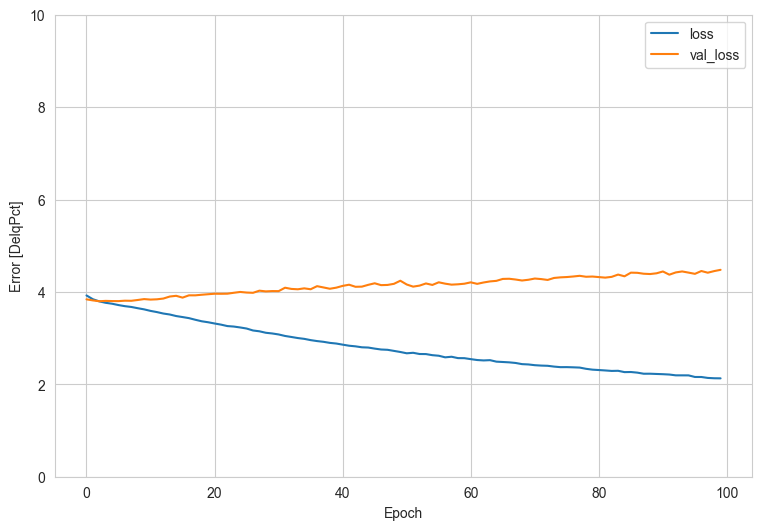

In [157]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [DelqPct]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

#Overfitting is when the model fits the training data too closely, and the loss keeps decreasing while the val_loss is stale, or increases.
#which looks to be exactly what is happening here

In [158]:
test_results = dict()
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [DelqPCT]']).T

,Mean absolute error [DelqPCT]
dnn_model,4.636332


42/42 [==============================] - 0s 3ms/step


2023-03-08 17:36:00.151962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[5.27033   4.968915  1.8313147 7.588837  1.6013578]
        DelqPct
185    0.000000
1919   0.000000
2669   0.000000
1688   9.313208
13141  0.000000


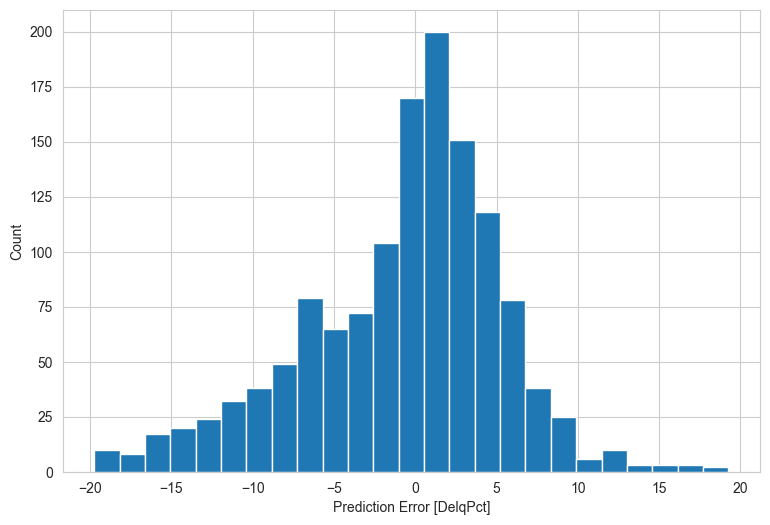

In [159]:
test_predictions = dnn_model.predict(test_features).flatten()

print(test_predictions[:5])
print(test_labels[:5])

error = test_predictions.reshape(test_predictions.shape[0],1) - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [DelqPct]')
_ = plt.ylabel('Count')

### XGBoost

In [160]:
xgdata = df.copy(deep=True)
for x in tqdm(range(1)):
    x_train, x_test, y_train, y_test = train_test_split(xgdata.iloc[:,:-1], xgdata.iloc[:,-1:], test_size=0.2)

    train = xgb.DMatrix(x_train, label=y_train)
    test = xgb.DMatrix(x_test, label=y_test)

    param = {
        'eta': 0.01,
        'objective': 'reg:squarederror',
    }
    epochs = 500

    model = xgb.train(param, train, epochs)

    predictions = model.predict(test)

    y = []

    for z in predictions:
        y.append(np.argmax(z))

    acc = round(metrics.mean_squared_error(y_test, y, squared=False), 3)
    model.save_model('Models/Delq/XGBoost_{}%_Scorelate.json'.format(acc))

100%|██████████| 1/1 [00:05<00:00,  5.51s/it]


[14.050909   9.244007   4.9111876 11.653531   7.15733  ]
       DelqPct
777        0.0
8098       0.0
7537       0.0
8521       0.0
12716      0.0


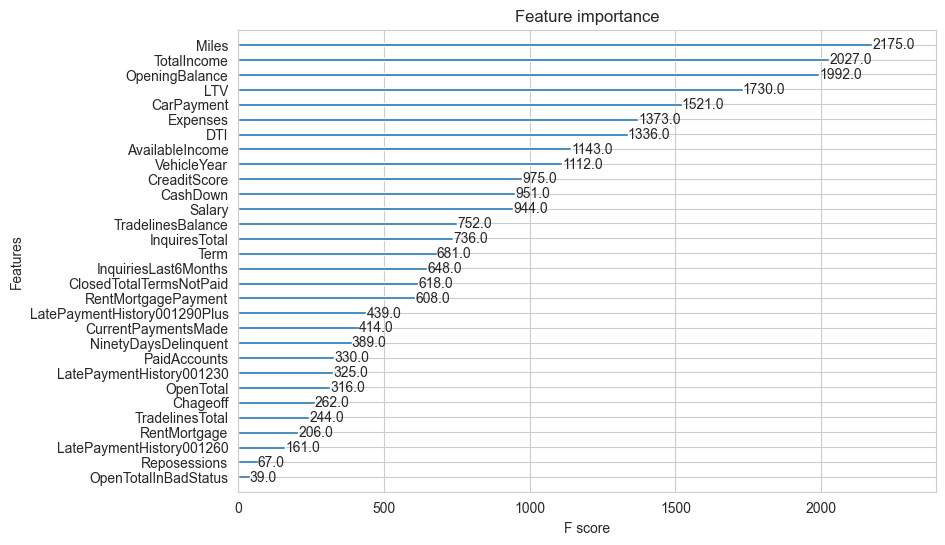

In [163]:
xgb_ml = xgb.Booster()

xgb_ml.load_model('Models/Delq/XGBoost_9.288%_Scorelate.json')
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1:], test_size=0.2)
print(xgb_ml.predict(xgb.DMatrix(x_test[:5])))
print(y_test[:5])


# plot feature importance
plot_importance(xgb_ml)
plt.show()